In [107]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: C:\Users\abelb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


*2.- CNN PREDICCION*

In [108]:
import numpy as np
import pandas as pd
import pathlib
import os

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.metrics import r2_score

*PREPARACION DEL ENTORNO PARA LA CREACION DE LA CNN*

In [109]:
#Se busca y se obtienen los path de las imagenes a utilizar en la CNN.
img_paths = ['images/img2/{}'.format(img) for img in os.listdir('./images/img2/')]

In [110]:
#Se lee el csv que contiene los parametros de las flores Iris.
dataset = pd.read_csv('./csv/Iris.csv').drop(["Id", "Species"], axis=1)

dataset

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [111]:
#Se crea objeto Dataframe con pandas para contener y combinar todos los parametros de las flores para cada flor. La referencia de la flor es el path de esta.
data = pd.DataFrame({
    "Filepath": [x for x in img_paths],
    "SepalLenght": dataset["SepalLengthCm"],
    "SepalWidth": dataset["SepalWidthCm"],
    "PetalLength": dataset["PetalLengthCm"],
    "PetalWidth": dataset["PetalWidthCm"]
})

*SEPARACION DE LA DATA EN ENTRENAMIENTO, VALIDACION Y TESTEO*

In [112]:
#Se randomiza el objeto Dataframe llamado data.
image_df = data.sample(150, random_state=1).reset_index(drop=True)

#Aca, se realiza el split para separar la data contenida en image_df, 70% del contenido en la variable train_df destinada al entrenamiento 
#y el 30% restante del contenido en la variable test_df destinada al testeo.
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [113]:
#En este apartado se crean los generadores que daran origen a la data de entrenamiento y testeo. Importante destacar que el 70% de la data destinada al 
#entrenamiento se separa en un 20% para la validacion del modelo y el 80% restante es el que se conserva para el entrenamiento del modelo.

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [114]:
train_df

,Filepath,SepalLenght,SepalWidth,PetalLength,PetalWidth
118,images/img2/iris-virginica-7.png,6.5,3.0,5.2,2.0
18,images/img2/iris-setosa-38.png,5.4,3.4,1.5,0.4
4,images/img2/iris-virginica-38.png,7.9,3.8,6.4,2.0
45,images/img2/iris-virginica-26.png,7.7,2.6,6.9,2.3
59,images/img2/iris-versicolor-50.png,5.7,3.0,4.2,1.2
...,...,...,...,...,...
133,images/img2/iris-setosa-16.png,5.0,3.4,1.5,0.2
137,images/img2/iris-versicolor-1.png,7.0,3.2,4.7,1.4
72,images/img2/iris-virginica-44.png,6.0,3.0,4.8,1.8
140,images/img2/iris-setosa-32.png,5.0,3.0,1.6,0.2


*DATA YA SEPARADA CREADA PARA LO QUE RESPECTA AL ENTRENAMIENTO, VALIDACION Y TESTEO DE LA CNN*

In [115]:
#Se crean las variables train_images, val_images y test_images, las cuales se crean con sus respectivos generadores, se les define a cada una sus dataframe,
#sus columnas, tamano del target, entre otras. Interesante comentar que el dataframe de val_images es train_df al igual que el del train_images ya que val_images esta
#destinado a validar con los mismos datos de entrenamiento el modelo, con esto se asegura de que el modelo sieste aprendiendo.

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col=['SepalLenght', 'SepalWidth', 'PetalLength', 'PetalWidth'],
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col=['SepalLenght', 'SepalWidth', 'PetalLength', 'PetalWidth'],
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col=['SepalLenght', 'SepalWidth', 'PetalLength', 'PetalWidth'],
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 84 validated image filenames.
Found 21 validated image filenames.
Found 45 validated image filenames.


*ENTRENAMIENTO DE LA CNN CON SUS RESPECTIVAS CAPAS CREADAS*

In [116]:
#Se definen las capas de la CNN, siendo estas las vistas en clases. 
#Convolution, con un tamano de kernel definido, un filtro y la funcion de activacion relu.
#Pooling del tipo Maxpooling.
#Como ultima capa,se crea Dense, con la funcion de activacion relu.
#Por supuesto, esta la zona de Input y la zona de Output con la funcion de activacion relu.

inputs = tf.keras.Input(shape=(256, 256, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(4, activation='relu')(x)

#Se declara el modelo construido con su zona input y output correspondiente.
model = tf.keras.Model(inputs=inputs, outputs=outputs)

#Nose que se hace aca.
model.compile(
    optimizer='adam',
    loss='mse'
)

#Se procede a realizar el entrenamiento del modelo con la funcion fit. Con la data de entrenamiento y validacion, con una cantidad de epocas definidas y una 
#funcionalidad callback para poder visualizar por consola el comportamiento del modelo mientras se entrena.
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=15,
)

Epoch 1/15
3/3 [==============================] - 6s 1s/step - loss: 15.2041 - val_loss: 15.8856
Epoch 2/15
3/3 [==============================] - 3s 1s/step - loss: 14.6406 - val_loss: 15.3237
Epoch 3/15
3/3 [==============================] - 3s 1s/step - loss: 13.9978 - val_loss: 14.5613
Epoch 4/15
3/3 [==============================] - 3s 956ms/step - loss: 13.1814 - val_loss: 13.5478
Epoch 5/15
3/3 [==============================] - 3s 1s/step - loss: 12.1046 - val_loss: 12.4109
Epoch 6/15
3/3 [==============================] - 3s 1s/step - loss: 10.8753 - val_loss: 11.5696
Epoch 7/15
3/3 [==============================] - 3s 953ms/step - loss: 10.4405 - val_loss: 11.5863
Epoch 8/15
3/3 [==============================] - 3s 937ms/step - loss: 10.5281 - val_loss: 11.6502
Epoch 9/15
3/3 [==============================] - 3s 1s/step - loss: 10.4896 - val_loss: 11.3686
Epoch 10/15
3/3 [==============================] - 3s 1s/step - loss: 10.2100 - val_loss: 11.2327
Epoch 11/15
3/3 [===

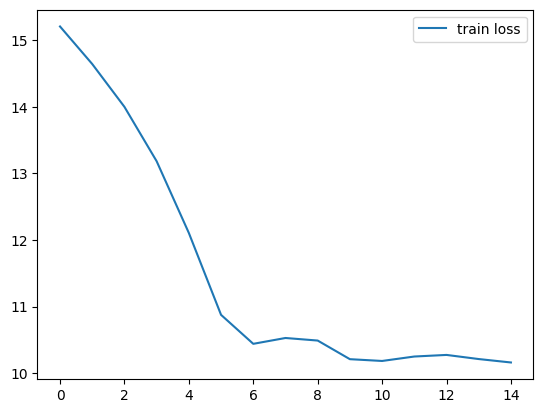

In [117]:
## validation loss and accuracy 
plt.plot(history.history['loss'], label = 'train loss')
#plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.legend()

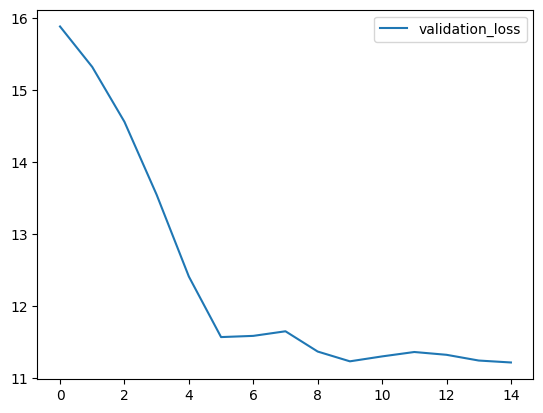

In [118]:
plt.plot(history.history['val_loss'], label = 'validation_loss')
#plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.legend()

In [119]:
#test_images
print(test_df['Filepath'])

14     images/img2/iris-versicolor-35.png
98      images/img2/iris-virginica-18.png
75     images/img2/iris-versicolor-31.png
16     images/img2/iris-versicolor-48.png
131     images/img2/iris-versicolor-2.png
56      images/img2/iris-virginica-33.png
141     images/img2/iris-virginica-40.png
44     images/img2/iris-versicolor-17.png
29       images/img2/iris-virginica-6.png
120         images/img2/iris-setosa-7.png
94      images/img2/iris-virginica-14.png
5      images/img2/iris-versicolor-15.png
102        images/img2/iris-setosa-47.png
51         images/img2/iris-setosa-42.png
78       images/img2/iris-virginica-1.png
42      images/img2/iris-virginica-27.png
92      images/img2/iris-virginica-37.png
66         images/img2/iris-setosa-15.png
31      images/img2/iris-virginica-41.png
35          images/img2/iris-setosa-8.png
90     images/img2/iris-versicolor-25.png
84         images/img2/iris-setosa-44.png
77     images/img2/iris-versicolor-49.png
40      images/img2/iris-virginica

*RESULTADOS DE LA PREDICCION DE LA CNN*

In [120]:
#Path de las imagenes utilizadas para el testeo de la CNN.
print(test_df['Filepath'] )

14     images/img2/iris-versicolor-35.png
98      images/img2/iris-virginica-18.png
75     images/img2/iris-versicolor-31.png
16     images/img2/iris-versicolor-48.png
131     images/img2/iris-versicolor-2.png
56      images/img2/iris-virginica-33.png
141     images/img2/iris-virginica-40.png
44     images/img2/iris-versicolor-17.png
29       images/img2/iris-virginica-6.png
120         images/img2/iris-setosa-7.png
94      images/img2/iris-virginica-14.png
5      images/img2/iris-versicolor-15.png
102        images/img2/iris-setosa-47.png
51         images/img2/iris-setosa-42.png
78       images/img2/iris-virginica-1.png
42      images/img2/iris-virginica-27.png
92      images/img2/iris-virginica-37.png
66         images/img2/iris-setosa-15.png
31      images/img2/iris-virginica-41.png
35          images/img2/iris-setosa-8.png
90     images/img2/iris-versicolor-25.png
84         images/img2/iris-setosa-44.png
77     images/img2/iris-versicolor-49.png
40      images/img2/iris-virginica

In [121]:
#Se le entrega al modelo la variable que contiene las imagenes a utilizar en el testeo de la CNN. Como resultado, entrega los parametros predichos 
#correspondientes a los path de las imagenes que se le entregan como referencia.
print(model.predict(test_images))

2/2 [==============================] - 2s 113ms/step
[[0.        2.889856  3.620141  0.       ]
 [0.        1.9729363 2.4892852 0.       ]
 [0.        3.0303257 3.791366  0.       ]
 [0.        3.146429  3.940761  0.       ]
 [0.        3.066387  3.8391109 0.       ]
 [0.        2.158619  2.7189708 0.       ]
 [0.        3.7252877 4.6582656 0.       ]
 [0.        3.0129364 3.7671518 0.       ]
 [0.        2.6939538 3.3880763 0.       ]
 [0.        3.2868621 4.10726   0.       ]
 [0.        2.8358517 3.5599337 0.       ]
 [0.        2.8971188 3.624514  0.       ]
 [0.        2.8807266 3.6131139 0.       ]
 [0.        2.1938126 2.7620852 0.       ]
 [0.        2.748611  3.4417183 0.       ]
 [0.        3.7582333 4.6996293 0.       ]
 [0.        2.9397247 3.6762166 0.       ]
 [0.        2.632187  3.292942  0.       ]
 [0.        2.037821  2.5621674 0.       ]
 [0.        3.5292146 4.4153256 0.       ]
 [0.        3.0809085 3.8563347 0.       ]
 [0.        3.0246637 3.789929  0.       ]
 

Con respecto a los resultados predichos, primero se realizo un analisis de cada parametro predicho con los que contiene el dataset Iris.csv.

1.- SepalLenght, los valores estan contenidos entre [4.3 , 7.9], entonces, si observamos los resultados, hay algunos que se escapan de los margenes, sobretodo menores a 4.3, esto es un fallo del modelo pero aun asi es en la minoria de los casos, por lo tanto el modelo puede ser de cierta forma creible en este aspecto.

2.- SepalWidth, los valores estan contenidos entre [2.0 , 4.0], entonces, si observamos los resultados, ocurre algo similar al anterior, algunos valores se escapan de los margenes y otros los contienen, tambien ocurre que son menores al margen minimo, esto siendo parte del error del modelo, en este caso tambien son la minoria, por lo tanto el modelo puede ser de cierta forma creible en este aspecto.

3.- PetalLength, los valores estan contenidos entre [ , ], entonces, si observamos los resultados,

4.- PetalWidth, los valores estan contenidos entre [ , ], entonces, si observamos los resultados,

In [122]:
img = tf.keras.preprocessing.image.load_img('data/img2/iris-setosa-43.png', target_size=(256,256))
img = tf.keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis=0)

model.predict(img)

FileNotFoundError: [Errno 2] No such file or directory: 'data/img2/iris-setosa-43.png'

In [ ]:
data.mean()

C:\Users\rodri\AppData\Local\Temp\ipykernel_10444\531903386.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.mean()


SepalLenght    5.843333
SepalWidth     3.054000
PetalLength    3.758667
PetalWidth     1.198667
dtype: float64

In [ ]:
data.std()

C:\Users\rodri\AppData\Local\Temp\ipykernel_10444\2723740006.py:1: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.std()


SepalLenght    0.828066
SepalWidth     0.433594
PetalLength    1.764420
PetalWidth     0.763161
dtype: float64